<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/rlberry_evaluate_and_optimize_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate an agent and optimize its hyperparameters with `rlberry`

## Colab Setup

In [1]:
from IPython import get_ipython
COLAB = False
if 'google.colab' in str(get_ipython()):
    COLAB = True

if COLAB:
    # install rlberry library
    !git clone https://github.com/rlberry-py/rlberry.git 
    !cd rlberry && git pull && pip install -e .[full] > /dev/null 2>&1

    # install ffmpeg-python for saving videos
    !pip install ffmpeg-python > /dev/null 2>&1

    # install optuna for hyperparameter optimization
    !pip install optuna > /dev/null 2>&1

    # packages required to show video
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    print("")
    print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
    print("")


fatal: destination path 'rlberry' already exists and is not an empty directory.
Already up to date.

 ~~~  Libraries installed, please restart the runtime! ~~~ 



## `AgentStats`: training several instances of an agent

The class `AgentStats` can be used to train several instances of an agent (in parallel), optimize its hyperparameters and analyze its performance.

Check the code below to learn how!

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
[INFO] Training AgentStats for REINFORCE...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [REINFORCE] | max_global_step = 132 | episode_rewards = 36.0 | dw_time_elapsed = 3.023165890999991 |  
[INFO] [REINFORCE] | max_global_step = 136 | episode_rewards = 81.0 | dw_time_elapsed = 3.062171167999992 |  
[INFO] [REINFORCE] | max_global_step = 285 | episode_rewards = 34.0 | dw_time_elapsed = 6.049430414999989 |  
[INFO] [REINFORCE] | max_global_step = 282 | episode_rewards = 18.0 | dw_time_elapsed = 6.064722638999996 |  
[INFO] [REINFORCE] | max_global_step = 424 | episode_rewards = 18.0 | dw_time_elapsed = 9.06463327199998 |  
[INFO] [REINFORCE] | max_global_step = 422 | episode_rewards = 43.0 | dw_time_elapsed = 9.08531575500001 |  
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


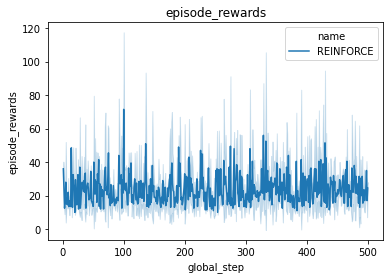

In [2]:
from rlberry.envs import gym_make
from rlberry.agents.torch.reinforce import REINFORCEAgent
from rlberry.stats import AgentStats, plot_writer_data


# Environment
env_ctor = gym_make
env_kwargs = dict(id='CartPole-v0')
env = env_ctor(**env_kwargs)

# Initial set of parameters
params = dict(
    gamma=0.99,
    horizon=200
)

# Create AgentStats to fit 2 instances of REINFORCE in parallel.
stats = AgentStats(REINFORCEAgent,
                   (env_ctor, env_kwargs),
                   fit_budget=500,   # number of episodes
                   init_kwargs=params,
                   eval_kwargs=dict(eval_horizon=200),
                   n_fit=2,
                   parallelization='thread')

# Fit the 4 instances
stats.fit()

# The fit() method of REINFORCEAgent writes data to a DefaultWriter (rlberry.utils.writer)
# object, which can be plotted with the method below.
plot_writer_data(stats, tag='episode_rewards')

## `AgentStats`: optimizing hyperparameters

The agent was not able to learn with the previous set of hyperparameters. Let's see if we can make it work by optimizing these parameters!

`REINFORCEAgent` implements a method `sample_hyperparameters`, which allows `AgentStats` to search for the best configuration of hyperparameters. In the class `REINFORCEAgent`, we have:

```python
@classmethod
def sample_parameters(cls, trial):
    """
    Sample hyperparameters for hyperparam optimization using
    Optuna (https://optuna.org/)

    Note: only the kwargs sent to __init__ are optimized. Make sure to
    include in the Agent constructor all "optimizable" parameters.

    Parameters
    ----------
    trial: optuna.trial
    """
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16, 32])
    gamma = trial.suggest_categorical('gamma', [0.9, 0.95, 0.99])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    entr_coef = trial.suggest_loguniform('entr_coef', 1e-8, 0.1)

    return {
            'batch_size': batch_size,
            'gamma': gamma,
            'learning_rate': learning_rate,
            'entr_coef': entr_coef,
            }
```


Connected to temp/stats_REINFORCE_1631001389/data_1401302146030241631001389.db (sqlite3 version = 2.6.0)


[I 2021-09-07 07:56:41,071] A new study created in RDB with name: no-name-2643034d-2557-4b56-bbd5-ccba1ce3a158
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] Saved AgentStats(REINFORCE) using pickle. 
[INFO] Training AgentStats for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Sucessful call to AgentHandler.load() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[I 2021-09-07 07:56:43,362] Trial 0 finished with value: 9.2 and parameters: {'batch_size': 8, 'gamma': 0.95, 'learning_rate': 0.46971013343232615, 'entr_coef': 7.860187512722006e-08}. Best is trial 0 with value: 9.2.


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Training AgentStats for optim...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Sucessful call to AgentHandler.load() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[I 2021-09-07 07:57:01,869] Trial 1 finished with value: 200.0 and parameters: {'batch_size': 8, 'gamma': 0.95, 'learning_rate': 0.004284268065832998, 'entr_coef': 6.142575637318156e-07}. Best is trial 1 with value: 200.0.
[INFO] Number of finished trials: 2 
[INFO] Best trial: 
[INFO] Value: 200.0 
[INFO] Params: 
[INFO]     batch_size: 8 
[INFO]     entr_coef: 6.142575637318156e-07 
[INFO]     gamma: 0.95 
[INFO]     learning_rate: 0.004284268065832998 
[INFO] Training AgentStats for REINFORCE...  
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


{'batch_size': 8, 'entr_coef': 6.142575637318156e-07, 'gamma': 0.95, 'learning_rate': 0.004284268065832998}
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


[INFO] [REINFORCE] | max_global_step = 101 | episode_rewards = 188.0 | dw_time_elapsed = 3.047201811000008 |  
[INFO] [REINFORCE] | max_global_step = 105 | episode_rewards = 88.0 | dw_time_elapsed = 3.07677321700001 |  
[INFO] [REINFORCE] | max_global_step = 147 | episode_rewards = 56.0 | dw_time_elapsed = 6.050531250000006 |  
[INFO] [REINFORCE] | max_global_step = 155 | episode_rewards = 200.0 | dw_time_elapsed = 6.101706653000008 |  
[INFO] [REINFORCE] | max_global_step = 178 | episode_rewards = 179.0 | dw_time_elapsed = 9.145423531000006 |  
[INFO] [REINFORCE] | max_global_step = 187 | episode_rewards = 168.0 | dw_time_elapsed = 9.145611599999995 |  
[INFO] [REINFORCE] | max_global_step = 203 | episode_rewards = 168.0 | dw_time_elapsed = 12.178723340999994 |  
[INFO] [REINFORCE] | max_global_step = 210 | episode_rewards = 200.0 | dw_time_elapsed = 12.18003465000001 |  
[INFO] [REINFORCE] | max_global_step = 232 | episode_rewards = 121.0 | dw_time_elapsed = 15.204755382000002 |  
[I

INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


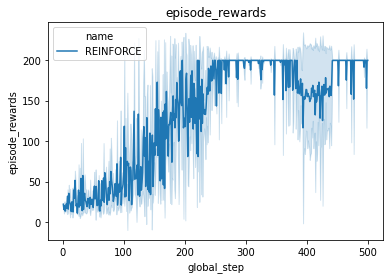

In [3]:
# Run optimization and print results
stats.optimize_hyperparams(
    n_trials=100,
    timeout=10,   # stop after 120 seconds
    n_fit=1,
    sampler_method='optuna_default'
)

print(stats.best_hyperparams)

# Calling fit() again will train the agent with the optimized parameters
stats.fit()
plot_writer_data(stats, tag='episode_rewards')

In [5]:
# Visualize the agent

import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video
from gym.wrappers import Monitor

# wrap env
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

# take one of the trained agents
agent = stats.agent_handlers[0]

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = agent.policy(state)
        state, reward, done, info = env.step(action)
env.close()
show_video(directory="./gym-results")

INFO: Starting new video recorder writing to /content/gym-results/openaigym.video.0.494.video000000.mp4
INFO: Starting new video recorder writing to /content/gym-results/openaigym.video.1.494.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym-results')
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym-results')


In [6]:
# clear data
stats.clear_output_dir()